# Super Resolution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn
import torch
import torchvision.transforms.v2 as transforms
from torchinfo import summary
from lightning import Trainer
from lightning.pytorch.tuner.tuning import Tuner

from nimrod.image.datasets import ImageDataset, ImageDataModule, ImageSuperResDataModule, ImageSuperResDataset
from nimrod.models.core import lr_finder, train_one_cycle, Regressor
from nimrod.models.resnet import ResBlock
from nimrod.utils import get_device, set_seed
from nimrod.models.superres import SuperResAutoencoder, SuperResAutoencoderX, UpBlock

from hydra.utils import instantiate
from omegaconf import OmegaConf
from rich import print
from typing import Optional, Type, List, Callable, Any
import matplotlib.pyplot as plt
from functools import partial
import logging

set_seed(42)
logger = logging.getLogger(__name__)
device = get_device()

Seed set to 42
/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Seed set to 42
Seed set to 42
Seed set to 42
[17:38:26] INFO - Using device: cuda
Seed set to 42
[17:38:26] INFO - Using device: cuda


## Manual Training Loop

### Data

In [3]:
#| notest

cfg = OmegaConf.load('../config/data/image/tiny_imagenet_superres.yaml')
cfg.batch_size = 512
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()

[17:38:26] INFO - Init ImageSuperResDataModule for slegroux/tiny-imagenet-200-clean
[17:38:26] INFO - Init ImageDataModule for slegroux/tiny-imagenet-200-clean


/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'transforms' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['transforms'])`.
[17:38:29] INFO - loading dataset slegroux/tiny-imagenet-200-clean with args () from split train
[17:38:29] INFO - loading dataset slegroux/tiny-imagenet-200-clean from split train
Overwrite dataset info from restored data version if exists.
[17:38:30] INFO - Overwrite dataset info from restored data version if exists.
Loading Dataset info from ../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2
[17:38:30] INFO - Loading Dataset info from ../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2
Found cached dataset tiny-imagenet-200-clean (/user/s/slegroux/Projects/nimrod/tutorials/../data/imag

### Model

In [9]:
# model
model = SuperResAutoencoder(n_features=[3, 8, 16, 32, 64, 128, 256]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [10]:
n_epochs = 1
losses = []
lrs = []
current_step = 0
total_steps = len(dm.train_dataloader()) * n_epochs
print(f"total_steps: {total_steps}")

for epoch in range(n_epochs):
    model.train()
    for low_res, high_res in dm.train_dataloader():

        optimizer.zero_grad()
        low_res = low_res.to(device)
        high_res = high_res.to(device)
        outputs = model(low_res)
        loss = criterion(outputs, high_res)        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        current_step += 1

    print(f"Epoch {epoch + 1}: Training Loss {loss.item():.4f}, Current LR: {current_lr:.10f}, Step: {current_step}/{total_steps}")
        

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for low_res, high_res in dm.test_dataloader():
            # model expects input (B,H*W)
            low_res = low_res.to(device)
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            # Pass the input through the model
            outputs = model(low_res)
            val_loss = criterion(outputs, high_res)
    print(f"Epoch {epoch + 1}: Validation Loss {val_loss.item():.4f}")


total_steps: 192

Epoch 1: Training Loss 0.6892, Current LR: 0.0003000000, Step: 192/192

Epoch 1: Validation Loss 0.6459

### Test

In [39]:
x = dm.train_ds[0][0].unsqueeze(0).to(device)
y_hat = model(x)
y_hat.shape

torch.Size([1, 3, 64, 64])

In [44]:
x_mean = torch.tensor([0.4822, 0.4495, 0.3985])
x_std = torch.tensor([0.2771, 0.2690, 0.2826])

tfm_norm = transforms.Normalize(mean=x_mean, std=x_std)
tfm_denorm = transforms.Compose([transforms.Normalize(mean=[0,0,0], std=1/x_std), transforms.Normalize(mean=-x_mean, std=[1,1,1])])


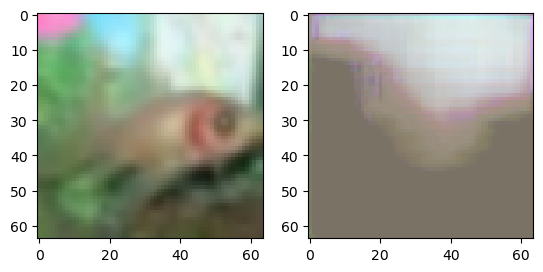

In [45]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(tfm_denorm(x[0]).permute(1, 2, 0).cpu().numpy())
ax[1].imshow(tfm_denorm(y_hat[0]).permute(1, 2, 0).detach().cpu().numpy())

## Nimrod Training loop

### Data

In [4]:
#| notest

cfg = OmegaConf.load('../config/data/image/tiny_imagenet_superres.yaml')
cfg.batch_size = 512
cfg.num_workers = 16
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()

[17:45:30] INFO - Init ImageSuperResDataModule for slegroux/tiny-imagenet-200-clean
[17:45:30] INFO - Init ImageDataModule for slegroux/tiny-imagenet-200-clean
[17:45:32] INFO - loading dataset slegroux/tiny-imagenet-200-clean with args () from split train
[17:45:32] INFO - loading dataset slegroux/tiny-imagenet-200-clean from split train
Overwrite dataset info from restored data version if exists.
[17:45:34] INFO - Overwrite dataset info from restored data version if exists.
Loading Dataset info from ../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2
[17:45:34] INFO - Loading Dataset info from ../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2
Found cached dataset tiny-imagenet-200-clean (/user/s/slegroux/Projects/nimrod/tutorials/../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2)
[17:45:34] INFO - Found cached dataset tiny-ima

### Loop

In [8]:
# import wandb
# wandb.finish()


In [ ]:
# SETUP
project_name = "TINY-Imagenet-Regression"

N_EPOCHS = 5
do_lr_finder = True
exp_logger = 'wandb'
precision = "16-mixed" # 16-mixed, 32-true
# n_features = [3, 16, 64, 128, 256, 512]
n_features = [3, 32, 64, 128, 256, 512, 1024]  # channel/feature expansion
# n_features = [3, 8, 16, 32]

cfg = OmegaConf.load('../config/model/image/autoencoderx.yaml')
print(cfg)
cfg.nnet.n_features = n_features  # channel/feature expansion
model = instantiate(cfg) #partial

tags = [
    f"precision:{precision}",
    f"n_features:{n_features}",
    f"bs:{dm.batch_size}",
    f"epochs:{N_EPOCHS}"
    ]

# LR Finder
if do_lr_finder:
    suggested_lr = lr_finder(model, dm, plot=True)
    print(f"Suggested learning rate: {suggested_lr}")
else:
    suggested_lr = 3e-4

# ONE-CYCLE TRAINING
best_ckpt_path = train_one_cycle(
    model,
    dm,
    n_epochs=N_EPOCHS,
    max_lr=suggested_lr,
    project_name=project_name,
    tags=tags,
    model_summary=False,
    logger_cb=exp_logger,
    )

Seed set to 42
Seed set to 42
[16:30:56] INFO - Using device: cuda


{'_target_': 'nimrod.models.superres.SuperResAutoencoderX', '_partial_': True, 'nnet': {'_target_': 
'nimrod.models.superres.SuperResAutoencoder', 'n_features': [3, 32, 64, 128, 256, 512, 1024], 'activation': 
{'_target_': 'torch.nn.LeakyReLU', '_partial_': True, 'negative_slope': 0.1}, 'leaky': 0.1}}

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[16:30:58] INFO - SuperResAutoencoderX: init
[16:30:58] INFO - Regressor: init
/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.


### Test

In [15]:
mdl = SuperResAutoencoderX.load_from_checkpoint(best_ckpt_path)

[16:23:39] INFO - SuperResAutoencoderX: init
[16:23:39] INFO - Regressor: init
/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.


tensor([52091])

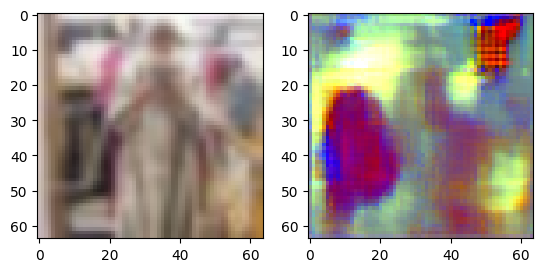

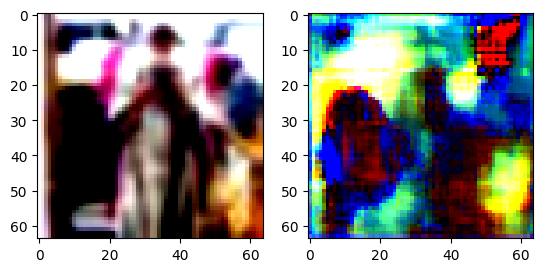

In [16]:
x_mean = torch.tensor([0.4822, 0.4495, 0.3985])
x_std = torch.tensor([0.2771, 0.2690, 0.2826])
tfm_norm = transforms.Normalize(mean=x_mean, std=x_std)
tfm_denorm = transforms.Compose([transforms.Normalize(mean=[0,0,0], std=1/x_std), transforms.Normalize(mean=-x_mean, std=[1,1,1])])

idx = torch.randint(0, len(dm.train_ds), (1,))
print(idx)
x = dm.train_ds[idx][0].unsqueeze(0).to(device)

y_hat = mdl(x)
y_hat.shape

fig, ax = plt.subplots(1, 2)
# fig.title("denormalize")
ax[0].imshow(tfm_denorm(x[0]).permute(1, 2, 0).cpu().numpy())
ax[1].imshow(tfm_denorm(y_hat[0]).permute(1, 2, 0).detach().cpu().numpy())

# fig.title("normalized")
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x[0].permute(1, 2, 0).cpu().numpy())
ax[1].imshow(y_hat[0].permute(1, 2, 0).detach().cpu().numpy())

## Tiny Unet

In [ ]:
#| notest

cfg = OmegaConf.load('../config/data/image/tiny_imagenet_superres.yaml')
cfg.batch_size = 512
cfg.num_workers = 16
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()

[17:45:30] INFO - Init ImageSuperResDataModule for slegroux/tiny-imagenet-200-clean
[17:45:30] INFO - Init ImageDataModule for slegroux/tiny-imagenet-200-clean
[17:45:32] INFO - loading dataset slegroux/tiny-imagenet-200-clean with args () from split train
[17:45:32] INFO - loading dataset slegroux/tiny-imagenet-200-clean from split train
Overwrite dataset info from restored data version if exists.
[17:45:34] INFO - Overwrite dataset info from restored data version if exists.
Loading Dataset info from ../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2
[17:45:34] INFO - Loading Dataset info from ../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2
Found cached dataset tiny-imagenet-200-clean (/user/s/slegroux/Projects/nimrod/tutorials/../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2)
[17:45:34] INFO - Found cached dataset tiny-ima

{'_target_': 'nimrod.models.unet.TinyUnetX', '_partial_': True, 'nnet': {'_target_': 'nimrod.models.unet.TinyUnet',
'n_features': [3, 32, 64, 128, 256, 512, 1024], 'activation': {'_target_': 'torch.nn.LeakyReLU', '_partial_': True,
'negative_slope': 0.1}, 'leaky': 0.1}}

Seed set to 42
[17:47:28] WARNING - setting conv bias back to False as Batchnorm is used
[17:47:28] WARNING - setting conv bias back to False as Batchnorm is used
[17:47:28] WARNING - setting conv bias back to False as Batchnorm is used
[17:47:28] WARNING - setting conv bias back to False as Batchnorm is used
[17:47:28] WARNING - setting conv bias back to False as Batchnorm is used
[17:47:28] WARNING - setting conv bias back to False as Batchnorm is used
[17:47:28] WARNING - setting conv bias back to False as Batchnorm is used
[17:47:28] WARNING - setting conv bias back to False as Batchnorm is used
[17:47:28] WARNING - setting conv bias back to False as Batchnorm is used
[17:47:28] WARNING - setting conv bias back to False as Batchnorm is used
[17:47:28] WARNING - setting conv bias back to False as Batchnorm is used
[17:47:28] WARNING - setting conv bias back to False as Batchnorm is used
[17:47:28] WARNING - setting conv bias back to False as Batchnorm is used
[17:47:28] WARNING - se

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 3.548133892335755e-05
Restoring states from the checkpoint path at /user/s/slegroux/Projects/nimrod/tutorials/.lr_find_ab0b6f3f-874c-45d9-b898-3935fdea1e14.ckpt
Restored all states from the checkpoint at /user/s/slegroux/Projects/nimrod/tutorials/.lr_find_ab0b6f3f-874c-45d9-b898-3935fdea1e14.ckpt


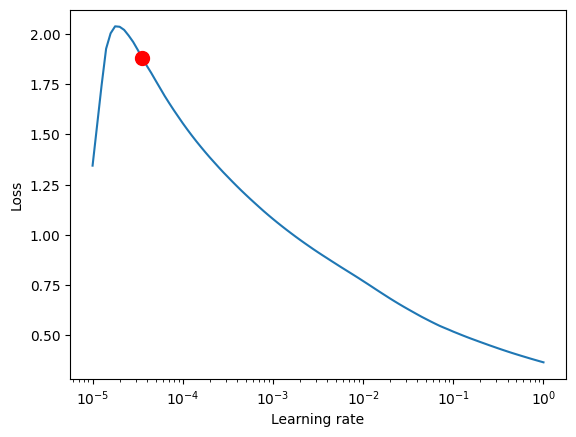

Suggested learning rate: 3.548133892335755e-05

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[17:48:11] INFO - SuperResAutoencoderX: init
[17:48:11] INFO - Regressor: init
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: slegroux. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[17:48:15] INFO - Regressor: configure_optimizers
[17:48:15] INFO - Optimizer: <class 'torch.optim.adamw.AdamW'>
[17:48:15] INFO - Scheduler: <class 'torch.optim.lr_scheduler.OneCycleLR'>

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | nnet         | TinyUnet         | 25.9 M | train
1 | criterion    | MSELoss          | 0      | train
2 | train_mse    | MeanSquaredError | 0      | train
3 | val_mse      | MeanSquaredError | 0      | train
4 | test_mse     | MeanSquaredError | 0      | train
5 | val_mse_best | MinMetric        | 0      | train
6 | train_loss   | MeanMetric       | 0      | train
7 | val_loss     | MeanMetric       | 0      | train
8 | test_loss    | MeanMetric       | 0      | train
----------------------------------------------------------
25.9 M    Trainable params
0         Non-trainable params
25.9 M    Total params
103.460   Total estimated model params s

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# SETUP
project_name = "TINY-Imagenet-Regression"

N_EPOCHS = 5
do_lr_finder = True
exp_logger = 'wandb'
precision = "16-mixed" # 16-mixed, 32-true
# n_features = [3, 16, 64, 128, 256, 512]
n_features = [3, 32, 64, 128, 256, 512, 1024]  # channel/feature expansion
# n_features = [3, 8, 16, 32]

cfg = OmegaConf.load('../config/model/image/unetx.yaml')
print(cfg)
cfg.nnet.n_features = n_features  # channel/feature expansion
model = instantiate(cfg) #partial

tags = [
    f"precision:{precision}",
    f"n_features:{n_features}",
    f"bs:{dm.batch_size}",
    f"epochs:{N_EPOCHS}"
    ]

# LR Finder
if do_lr_finder:
    suggested_lr = lr_finder(model, dm, plot=True)
    print(f"Suggested learning rate: {suggested_lr}")
else:
    suggested_lr = 3e-4

# ONE-CYCLE TRAINING
best_ckpt_path = train_one_cycle(
    model,
    dm,
    n_epochs=N_EPOCHS,
    max_lr=suggested_lr,
    project_name=project_name,
    tags=tags,
    model_summary=False,
    logger_cb=exp_logger,
    )